In [1]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 11.8 MB/s 
     |████████████████████████████████| 62 kB 814 kB/s 


In [2]:
!pip install wget wfdb neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 14.4 MB/s 
     |████████████████████████████████| 1.2 MB 14.1 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=fb3fd9731a14240bd2c25f569cc631ff12334eeb9da4faa64f4bb08d6da25e2c
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json'

kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [4]:
!kaggle datasets download -d bjoernjostein/georgia-12lead-ecg-challenge-database

100% 482M/483M [00:16<00:00, 35.5MB/s]
100% 483M/483M [00:16<00:00, 30.1MB/s]


In [5]:
!kaggle datasets download -d bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database

 99% 561M/564M [00:20<00:00, 27.5MB/s]
100% 564M/564M [00:21<00:00, 28.1MB/s]


In [6]:
!kaggle datasets download -d bjoernjostein/china-12lead-ecg-challenge-database

 99% 403M/406M [00:14<00:00, 34.8MB/s]
100% 406M/406M [00:14<00:00, 29.2MB/s]


In [7]:
!kaggle datasets download -d bjoernjostein/china-physiological-signal-challenge-in-2018

100% 820M/824M [00:27<00:00, 29.1MB/s]
100% 824M/824M [00:27<00:00, 31.7MB/s]


In [8]:
!kaggle datasets download -d bjoernjostein/physionet-challenge-2021-snomed-mappings

  0% 0.00/4.13k [00:00<?, ?B/s]
100% 4.13k/4.13k [00:00<00:00, 3.82MB/s]


In [9]:
!kaggle datasets download -d erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database

 99% 543M/547M [00:20<00:00, 33.1MB/s]
100% 547M/547M [00:20<00:00, 27.7MB/s]


In [10]:
!kaggle datasets download -d erarayamorenzomuten/ningbo-first-hospital-12lead-ecg-database

100% 1.78G/1.78G [01:01<00:00, 36.8MB/s]
100% 1.78G/1.78G [01:01<00:00, 31.2MB/s]


In [11]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ECG-age.git'
DEST_NAME = 'ecg_age'
cloned_repo = Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

In [12]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [13]:
#this code is to move datasets to corresponding folders in the "data" folder
import shutil
import os
os.mkdir("/content/ecg_age/data")
sources = ['Training_2/',  'Training_StPetersburg/','Training_WFDB/','WFDB_ChapmanShaoxing/', 'WFDB_Ningbo/', "WFDB/"]
dest1 = '/content/ecg_age/data/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [14]:
from ecg_age.src.helpers.helpers import *
from ecg_age.src.models.models import *

In [15]:
import pandas as pd
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
#from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

In [16]:
select_gender="both"

In [17]:
print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecg_len, ecg_filenames = import_key_data("/content/ecg_age/data/")
ecg_filenames = np.asarray(ecg_filenames)
age = np.asarray(age)
gender = np.asarray(gender)
ecg_len = np.asarray(ecg_len)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 131800/131800 [02:38<00:00, 830.45it/s]


Total number of patients found: 59490


In [18]:
print("remove all ECGs not equal to 10 seconds")
age, gender,ecg_filenames, labels = only_ten_sec(ecg_len, age, gender, ecg_filenames, labels)

remove all ECGs not equal to 10 seconds


In [19]:
print("remove all ECGs with missing values in gender or age")
ecg_filenames, gender, age, labels = remove_nan_and_unknown_values(ecg_filenames, gender, age, labels)

remove all ECGs with missing values in gender or age


In [20]:
age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 59355


In [21]:
print("Select ECGs from males or females")
if select_gender != "both":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g=select_gender)
else:
    pass

Select ECGs from males or females


In [22]:
print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 59355


In [23]:
folds = split_data(age, gender,n_splits=3)

Training split: 39570
Validation split: 19785


In [24]:
def scheduler(epoch, lr):
    if epoch == 10:
        return lr * 0.1
    elif epoch == 15:
        return lr * 0.1
    elif epoch == 20:
        return lr * 0.1
    else:
        return lr

In [25]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [32]:
#choosing the model to train/test
model_name = "InceptionTime" # "InceptionTime" or "Attia"

In [33]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 20
mae_score_total = []
loss_curves_val = []
loss_curves = []
inference = False

print("Training model...")
for i in range(len(folds)):
    train_ind = folds[i][0]
    test_ind = folds[i][1]

    if model_name == "Attia":
        model = attia_network_age(samp_freq,time,num_leads) 
    elif model_name == "InceptionTime":
        model = build_model((samp_freq*time,num_leads), 1)
    history = model.fit(x=shuffle_batch_generator_age(batch_size=batchsize, gen_x=generate_X_age(ecg_filenames[train_ind],samp_freq=samp_freq,num_leads=num_leads), gen_y=generate_y_age(age[train_ind]),num_leads=num_leads, time=time, samp_freq=samp_freq), epochs=epoch, 
              steps_per_epoch=(len(train_ind)/batchsize), 
              validation_data=shuffle_batch_generator_age(batch_size=batchsize, gen_x=generate_X_age(ecg_filenames[test_ind],samp_freq=samp_freq,num_leads=num_leads), gen_y=generate_y_age(age[test_ind]),num_leads=num_leads,time=time, samp_freq=samp_freq), validation_freq=1, validation_steps = (len(test_ind)/batchsize),
              verbose = 1, 
              callbacks=[lr_schedule]
              )
    loss_curves_val.append(np.asarray(history.history["val_loss"]))
    loss_curves.append(np.asarray(history.history["loss"]))
    if inference == True:
      mse_score = []
      mae_score = []
      f1_score = []
      acc_score = []
      pred_age = []
      true_age = []
      for j in tqdm.tqdm(test_ind):
          data, header_data = load_challenge_data(ecg_filenames[j])
          if int(header_data[0].split(" ")[2]) != samp_freq:
              data_new = np.ones([num_leads,int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq)])
              for k,l in enumerate(data):
                  data_new[k] = signal.resample(l, int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq))
              data = data_new
              data = pad_sequences(data, maxlen=samp_freq*10, truncating='post',padding="post")
          data = np.moveaxis(data, 0, -1)
          y_true = age[j]
          true_age.append(y_true)
          y_hat = model.predict(np.expand_dims(data, axis=0), verbose=0)
          pred_age.append(y_hat)
          mse_score.append(mean_squared_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
          mae_score.append(mean_absolute_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
      mse_score = np.asarray(mse_score).mean()
      mae_score = np.asarray(mae_score).mean()
      print("MAE score {}".format(mae_score))
      print("MSE score {}".format(mse_score))
      mae_score_total.append(mae_score)




Training model...
Epoch 1/20
2473/2473 [==============================] - 285s 114ms/step - loss: 13.2829 - mean_squared_error: 364.9063 - val_loss: 10.2859 - val_mean_squared_error: 179.7988 - lr: 0.0010
Epoch 2/20
2473/2473 [==============================] - 282s 114ms/step - loss: 9.5445 - mean_squared_error: 160.7185 - val_loss: 9.0521 - val_mean_squared_error: 147.6928 - lr: 0.0010
Epoch 3/20
2473/2473 [==============================] - 285s 115ms/step - loss: 9.1909 - mean_squared_error: 150.8656 - val_loss: 8.8631 - val_mean_squared_error: 143.6806 - lr: 0.0010
Epoch 4/20
2473/2473 [==============================] - 284s 115ms/step - loss: 8.9541 - mean_squared_error: 144.2773 - val_loss: 8.9034 - val_mean_squared_error: 145.7111 - lr: 0.0010
Epoch 5/20
2473/2473 [==============================] - 283s 115ms/step - loss: 8.7379 - mean_squared_error: 138.7524 - val_loss: 8.8161 - val_mean_squared_error: 142.9591 - lr: 0.0010
Epoch 6/20
2473/2473 [==============================] -

In [64]:
np.linspace(1,20,20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

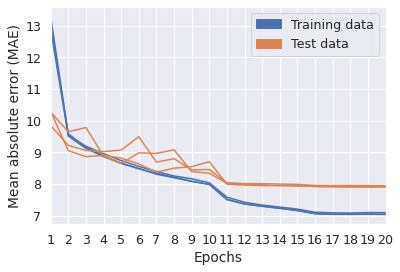

In [77]:
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(font_scale=1.15)

for i in loss_curves:
  plt.plot(np.linspace(1,20,20),i, "C0")
for j in loss_curves_val:
  plt.plot(np.linspace(1,20,20),j, "C1")
blue_patch = mpatches.Patch(color='C0', label='Training data')
orange_patch = mpatches.Patch(color='C1', label='Test data')
plt.xlim(1,20)
plt.xticks(np.linspace(1,20,20))
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error (MAE)")
plt.legend(handles=[blue_patch,orange_patch])
plt.savefig("Training curves.png", dpi=300, bbox_inch="tight")
plt.show()

In [55]:
history.history["loss"]

[12.896557807922363,
 9.512362480163574,
 9.122647285461426,
 8.866031646728516,
 8.650395393371582,
 8.47921371459961,
 8.339117050170898,
 8.211787223815918,
 8.086514472961426,
 7.988534450531006,
 7.519300937652588,
 7.366138458251953,
 7.292738914489746,
 7.225508689880371,
 7.166829586029053,
 7.060971736907959,
 7.042802333831787,
 7.037663459777832,
 7.049359321594238,
 7.0384063720703125]

In [31]:
history.history["val_loss"]

[9.898298263549805, 9.429804801940918]

In [ ]:
print("mean MAE score {}".format(np.asarray(mae_score_total).mean()))
print("std MAE score {}".format(np.asarray(mae_score_total).std()))

In [ ]:
d = {"True age": np.asarray(true_age).ravel(), 'Predicted age': np.asarray(pred_age).ravel(),'Error': abs(np.asarray(true_age).ravel() - np.asarray(pred_age).ravel())}
df = pd.DataFrame(data = d)

## Analysis:


### Comparing the predicted age vs the actual age. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["True age"],df["Predicted age"])
reg_line = (np.arange(101)*slope) + intercept
plt.figure(figsize=(30,15))
sns.set(font_scale=2)
sns.scatterplot(data=df, x="True age", y="Predicted age")
sns.set(font_scale=5)
plt.plot(np.arange(101),'red', label="1x + 0")
plt.plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
snomed_ct_codes = np.array(["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","164909002","251146004","698252002","426783006","284470004",
 "10370003","365413008","427172004","164947007","111975006","164917005","47665007","59118001","427393009","426177001","427084000","63593006","164934002","59931005","17338001"])


In [ ]:
diagnoses = np.array(["atrial fibrillation","atrial flutter","bundle branch block","bradycardia","complete left bundle branch block","complete right bundle branch block","1st degree av block","incomplete right bundle branch block","left axis deviation","left anterior fascicular block",
"left bundle branch block","low qrs voltages","nonspecific intraventricular conduction disorder","sinus rhythm","premature atrial contraction","pacing rhythm","poor R wave Progression","premature ventricular contractions","prolonged pr interval","prolonged qt interval",
"qwave abnormal","right axis deviation","right bundle branch block","sinus arrhythmia","sinus bradycardia","sinus tachycardia","supraventricular premature beats","t wave abnormal","t wave inversion","ventricular premature beats"])


In [ ]:
val_ecg_filenames =np.asarray(ecg_filenames)[test_ind]

In [ ]:
classes = set()
for ecg_file in tqdm.tqdm(val_ecg_filenames):
    header_file = ecg_file.replace('.mat','.hea')
    header = load_header(header_file)
    classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x))
else:
    classes = sorted(classes)
num_classes = len(classes)

In [ ]:
scored_classes = []
for i in classes:
    for j in snomed_ct_codes:
        if i == '':
            continue
        if i == j:
            scored_classes.append(i)
scored_classes = sorted(scored_classes)

In [ ]:
class_names = []
for j in range(len(scored_classes)):
    for i in range(len(snomed_ct_codes)):
        if (str(snomed_ct_codes[i]) == scored_classes[j]):
            class_names.append(diagnoses[i])

In [ ]:
num_recordings = len(val_ecg_filenames)
num_classes = len(scored_classes)
val_labels = np.zeros((num_recordings, num_classes), dtype=np.bool)

for i in range(len(val_ecg_filenames)):
    current_labels = get_labels(load_header(val_ecg_filenames[i].replace('.mat','.hea')))
    for lab in current_labels:
        if lab in scored_classes:
            j = scored_classes.index(lab)
        val_labels[i, j] = 1
val_labels = val_labels * 1

### Comparing the predicted age vs the actual age for 20 different cardiovascular diseases. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True)
fig.set_figheight(46)
fig.set_figwidth(46)
cnt = 0
cnt_2 = 0
for i in range(20):
    TE = np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]).sum()
    MAE = np.asarray(abs(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])).sum()/len(np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"],df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])
    ax[cnt_2,cnt].set_title(class_names[i] + ", MAE= {}".format(round(MAE,2)))
    df_temp = df.iloc[np.where(val_labels[:,i]==1)[0]]
    ax[cnt_2,cnt].scatter(df_temp["True age"],df_temp["Predicted age"])
    ax[cnt_2,cnt].plot(np.arange(101),'red', label="1x + 0")
    ax[cnt_2,cnt].plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
    ax[cnt_2,cnt].set_xlabel("True age")
    ax[cnt_2,cnt].set_ylabel("Predicted age")
    ax[cnt_2,cnt].legend()
    cnt += 1
    if cnt == 5:
        cnt_2 += 1
        cnt = 0



NameError: ignored